In [161]:
# Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False



In [162]:

df = pd.read_excel('failuretimes.xlsx', sheet_name='SYS1')

df.head()

,FN,IF,FT
0,1,3,3
1,2,30,33
2,3,113,146
3,4,81,227
4,5,115,342


In [163]:
## using univariate feature

X = df['FT']
Y = df['FN']
X.head()

0      3
1     33
2    146
3    227
4    342
Name: FT, dtype: int64

In [123]:
X = X.values

In [157]:
## train test split for simple time series 
train_split = 30
tf.random.set_seed(13)

### standardize data
X_mean = X[:train_split].mean()
X_std = X[:train_split].std()
X  = (X - X_mean)/ X_std
print(X_mean)
print(X_std)
print((X))


2.960594732333751e-17
1.0
[-1.13768175e+00 -1.11707821e+00 -1.03947154e+00 -9.83841980e-01
 -9.04861739e-01 -8.98680677e-01 -8.97307107e-01 -8.34809699e-01
 -7.57889813e-01 -7.47588042e-01 -6.52811753e-01 -6.18472518e-01
 -5.65590096e-01 -5.49107263e-01 -4.74934515e-01 -4.14497461e-01
  4.56482899e-02  1.28062454e-01  1.45918857e-01  2.24212313e-01
  4.47417341e-01  4.85190500e-01  6.51392398e-01  6.98093758e-01
  9.87916902e-01  1.11153815e+00  1.11840600e+00  1.90546127e+00
  2.31753209e+00  2.32783386e+00  2.35255811e+00  2.35530525e+00
  2.35530525e+00  2.36079952e+00  2.51669965e+00  2.56134066e+00
  2.68221476e+00  2.72204828e+00  3.03590889e+00  3.24194430e+00
  3.30856241e+00  3.48918679e+00  3.79961348e+00  3.97474358e+00
  4.11004016e+00  4.24258961e+00  4.24671032e+00  4.30096631e+00
  4.86138263e+00  5.78922876e+00  5.89087290e+00  5.90529538e+00
  6.06531621e+00  6.15734536e+00  6.40252750e+00  6.53507695e+00
  6.69715814e+00  6.71844846e+00  6.97187202e+00  7.48558698e+00

In [125]:
## utility functions

## funtion to create data for univariate forecasting

def sysdata(dataset, start_idx , end_idx , history_size, target_size):
  data = []
  labels = []
  start_idx  = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx):
    idxs = range(i-history_size , i)
    data.append(np.reshape(dataset[idxs] , (history_size, 1))) ### reshape data
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

X_past = 20   ## last 20 values
X_future = 0     ## future data

x_train , y_train = sysdata(X , 0 , train_split , X_past , X_future)

x_val , y_val = sysdata(X , train_split , None ,X_past , X_future)

In [126]:
print(x_train.shape , y_train.shape)
print(x_val.shape , y_val.shape)

(10, 20, 1) (10,)
(86, 20, 1) (86,)


In [127]:
print('Single STEP of past data' , x_train[0])

print('Target VALUE to predict ' , y_train[0])


Single STEP of past data [[-1.13768175]
 [-1.11707821]
 [-1.03947154]
 [-0.98384198]
 [-0.90486174]
 [-0.89868068]
 [-0.89730711]
 [-0.8348097 ]
 [-0.75788981]
 [-0.74758804]
 [-0.65281175]
 [-0.61847252]
 [-0.5655901 ]
 [-0.54910726]
 [-0.47493451]
 [-0.41449746]
 [ 0.04564829]
 [ 0.12806245]
 [ 0.14591886]
 [ 0.22421231]]
Target VALUE to predict  0.4474173411656144


<module 'matplotlib.pyplot' from 'C:\\Users\\navee\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

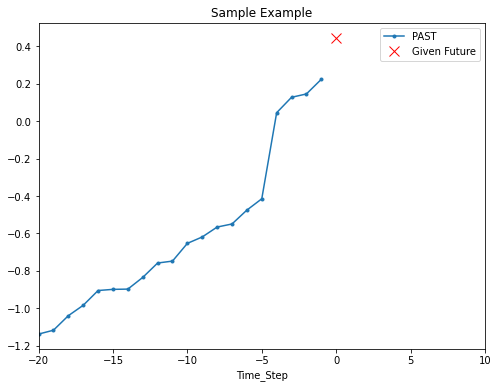

In [128]:
### fucntion to create time steps
def create_time_steps(length):
    return list(range(-length,0))

### function to plot time series data

def plot_time_series(plot_data, pred , title):
    labels = ["PAST" , 'Given Future' , 'prediction']
    marker = ['.-' , 'rx' , 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])

    if pred:
        future = pred
    else:
        future = 0
    plt.title(title)
    for i , x in enumerate(plot_data):
        if i :
            plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5) *2])

    plt.xlabel('Time_Step')
    return plt

plot_time_series([x_train[0] , y_train[0]] , 0 , 'Sample Example')

<module 'matplotlib.pyplot' from 'C:\\Users\\navee\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

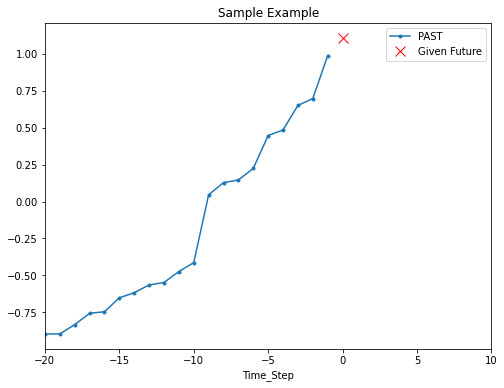

In [129]:
i = 5
plot_time_series([x_train[i], y_train[i]] , 0 , 'Sample Example')

In [130]:
## prepare tensorflow dataset Univariate time-series forecasting
batch_size = 32
buffer_size = 100

train = tf.data.Dataset.from_tensor_slices((x_train , y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).repeat()

val = tf.data.Dataset.from_tensor_slices((x_val , y_val))
val = val.cache().shuffle(buffer_size).batch(batch_size).repeat()

# print(train)
# print(val)
print(x_train.shape[-2:])

(20, 1)


In [151]:
## SimpleRNN model 

model = tf.keras.models.Sequential([tf.keras.layers.SimpleRNN(16 , input_shape = (20,1)), 
                                         tf.keras.layers.Dense(1), tf.keras.layers.Dense(1)])

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = 'accuracy')

steps = 200

EPOCHS =10

model.fit(train , epochs = EPOCHS, steps_per_epoch = steps ,
               validation_data = val, validation_steps = 50)
model.summary()


Epoch 1/10
200/200 [==============================] - 5s 15ms/step - loss: 0.8553 - accuracy: 0.0000e+00 - val_loss: 754.9992 - val_accuracy: 0.0000e+00
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0192 - accuracy: 0.0000e+00 - val_loss: 742.7506 - val_accuracy: 0.0000e+00
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0082 - accuracy: 0.0000e+00 - val_loss: 745.5364 - val_accuracy: 0.0000e+00
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0059 - accuracy: 0.0000e+00 - val_loss: 745.9955 - val_accuracy: 0.0000e+00
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 749.9476 - val_accuracy: 0.0000e+00
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - val_loss: 748.3197 - val_accuracy: 0.0000e+00
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 9.0463e-04 - 

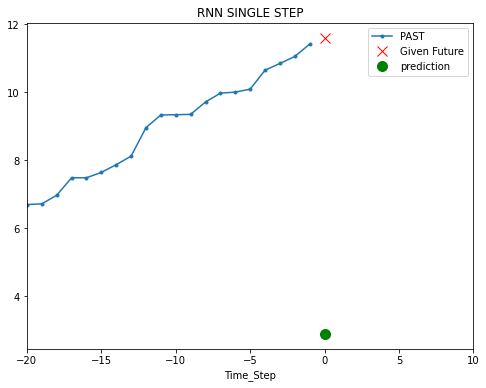

In [132]:
for i , j in val.take(1):
    plot = plot_time_series([i[0].numpy() , j[0].numpy() , model.predict(i)[0]] ,0 , 'RNN SINGLE STEP')
    plot.show()

In [133]:
## features Multivariate and Single step Forecasting

features = ['FT','IF']

features = df[features]
target = df['FN']
features.head()


,FT,IF
0,3,3
1,33,30
2,146,113
3,227,81
4,342,115


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

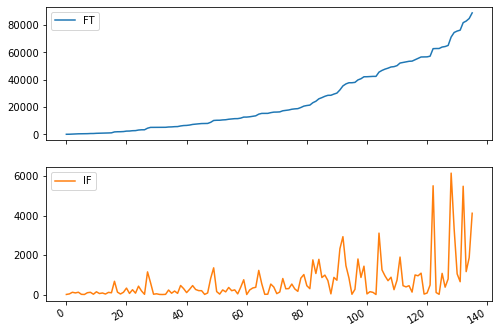

In [134]:
features.plot(subplots=True)

In [135]:
### standardize data
dataset = features.values

data_mean = dataset[:train_split].mean(axis =0)

data_std = dataset[:train_split].std(axis = 0)

dataset = (dataset - data_mean)/data_std



In [136]:
### create mutlivariate data

def sys1data(dataset , target , start_idx , end_idx , history_size , target_size,
                      step ,  single_step = False):
  data = []
  labels = []
  start_idx = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx ):
    idxs = range(i-history_size, i, step) ### using step
    data.append(dataset[idxs])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data) , np.array(labels)



In [137]:
### generate multivariate data

history = 20
future_target = 10
STEP = 6

x_train_sys , y_train_sys = sys1data(dataset , dataset[:, 1], 0, train_split, history,
                                            future_target, STEP , single_step = True)

x_val_sys , y_val_sys = sys1data(dataset , dataset[:,1] , train_split , None , history ,
                                        future_target, STEP, single_step = True)

print(x_train_sys.shape , y_train_sys.shape)


(10, 4, 2) (10,)


In [138]:
## tensorflow dataset

train_sys = tf.data.Dataset.from_tensor_slices((x_train_sys, y_train_sys))
train_sys = train_sys.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_sys = tf.data.Dataset.from_tensor_slices((x_val_sys, y_val_sys))
val_sys = val_sys.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_sys)
print(val_sys)
print(x_train_sys.shape[-2:])


<RepeatDataset shapes: ((None, 4, 2), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 4, 2), (None,)), types: (tf.float64, tf.float64)>
(4, 2)


In [139]:
### Modelling using LSTM

single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.SimpleRNN(32, input_shape =(4, 2)))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mean_squared_error')
single_step_model_history = single_step_model.fit(train_sys, epochs = EPOCHS , 
                                                  steps_per_epoch =steps, validation_data = val_sys,
                                                  validation_steps = 50)


Epoch 1/10
200/200 [==============================] - 2s 3ms/step - loss: 0.1288 - val_loss: 29.3417
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 29.3491
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 3.6847e-04 - val_loss: 29.7531
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 3.2090e-06 - val_loss: 30.0704
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 8.2289e-09 - val_loss: 29.9717
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 7.8663e-12 - val_loss: 30.1690
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 7.6816e-14 - val_loss: 29.6050
Epoch 8/10
200/200 [==============================] - 1s 4ms/step - loss: 2.6169e-14 - val_loss: 29.8264
Epoch 9/10
200/200 [==============================] - 1s 4ms/step - loss: 3.9306e-14 - val_loss: 30.0508
Epoch 10/10
200/200 [==============================] - 1s 6ms/s

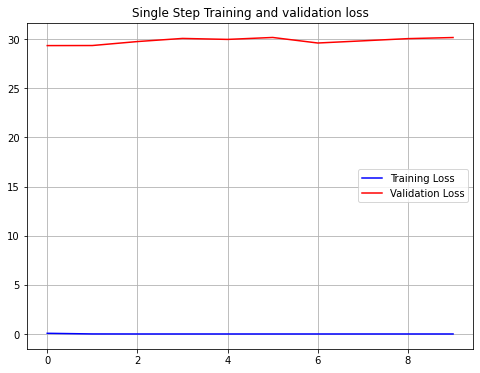

In [140]:
## plot train test loss 

def plotloss(history , title):
  loss = history.history['loss']
  valloss = history.history['val_loss']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Training Loss')
  plt.plot(epochs, valloss , 'r' , label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()

plotloss(single_step_model_history , 'Single Step Training and validation loss')

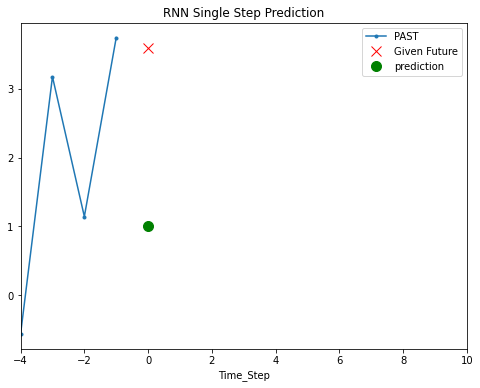

In [141]:
# plot time series and predicted values

for x, y in val_sys.take(1):
  plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 0,
                   'RNN Single Step Prediction')
  plot.show()

In [142]:
# Multi-variate & multi-step forecasting -> Generate multiple future values of failures
future_target = 72 # 72 future values
x_train_multi, y_train_multi = sys1data(dataset, dataset[:, 1], 0,
                                                 train_split, history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = sys1data(dataset, dataset[:, 1],
                                             train_split, None, history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

(10, 4, 2)
(10, 72)


In [143]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

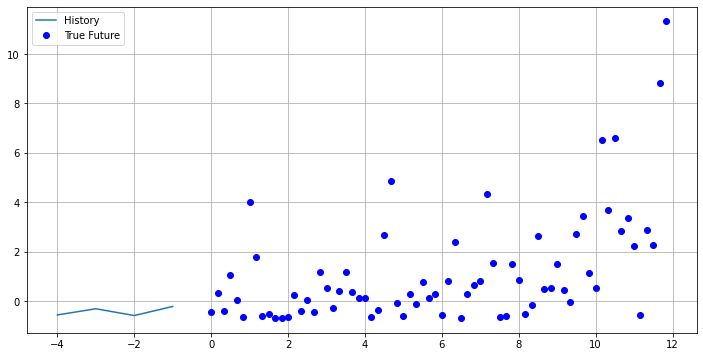

(4, 2)


In [144]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

print(x_train_multi.shape[-2:])

In [145]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.SimpleRNN(32,
                                          return_sequences=True,
                                          input_shape=(4,2)))
multi_step_model.add(tf.keras.layers.SimpleRNN(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=steps,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 6ms/step - loss: 1.3841 - val_loss: 2.9645
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.9274 - val_loss: 3.1064
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.7662 - val_loss: 3.2354
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6387 - val_loss: 3.2580
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5287 - val_loss: 3.3419
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4467 - val_loss: 3.4032
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3778 - val_loss: 3.4922
Epoch 8/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3268 - val_loss: 3.5673
Epoch 9/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2938 - val_loss: 3.6145
Epoch 10/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2673 - val_loss: 3.6463

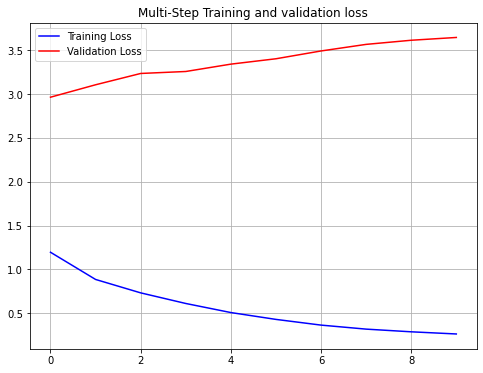

In [146]:
plotloss(multi_step_history, 'Multi-Step Training and validation loss')


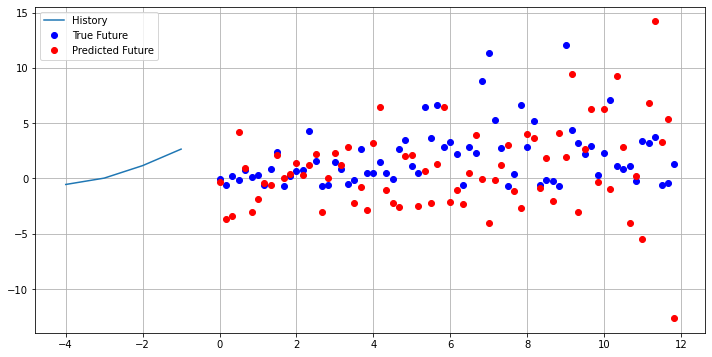

In [147]:
for x, y in val_data_multi.take(1):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])